<a href="https://colab.research.google.com/github/filiperobotic/cursoDL/blob/master/codes/aula6/breast_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/filiperobotic/cursoDL.git

In [0]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import SeparableConv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

Using TensorFlow backend.


In [0]:
def build(width, height, depth, classes):
		#TODO

		# return the constructed network architecture
		return model

In [0]:
# USAGE
# python train_model.py

# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adagrad
from keras.utils import np_utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os



# initialize our number of epochs, initial learning rate, and batch
# size
NUM_EPOCHS = 2
INIT_LR = 1e-2
BS = 32

TRAIN_PATH = "cursoDL/imagens/datasets/breast_cancer/training"
VAL_PATH = "cursoDL/imagens/datasets/breast_cancer/validation"
TEST_PATH = "cursoDL/imagens/datasets/breast_cancer/testing"

# determine the total number of image paths in training, validation,
# and testing directories
trainPaths = list(paths.list_images(TRAIN_PATH))
totalTrain = len(trainPaths)
totalVal = len(list(paths.list_images(VAL_PATH)))
totalTest = len(list(paths.list_images(TEST_PATH)))

# account for skew in the labeled data
trainLabels = [int(p.split(os.path.sep)[-2]) for p in trainPaths]
trainLabels = np_utils.to_categorical(trainLabels)
classTotals = trainLabels.sum(axis=0)
classWeight = classTotals.max() / classTotals

# initialize the training training data augmentation object
trainAug = ImageDataGenerator(
	rescale=1 / 255.0,
	rotation_range=20,
	zoom_range=0.05,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.05,
	horizontal_flip=True,
	vertical_flip=True,
	fill_mode="nearest")

# initialize the validation (and testing) data augmentation object
valAug = ImageDataGenerator(rescale=1 / 255.0)

# initialize the training generator
trainGen = trainAug.flow_from_directory(
	TRAIN_PATH,
	class_mode="categorical",
	target_size=(48, 48),
	color_mode="rgb",
	shuffle=True,
	batch_size=BS)

# initialize the validation generator
valGen = valAug.flow_from_directory(
	VAL_PATH,
	class_mode="categorical",
	target_size=(48, 48),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS)

# initialize the testing generator
testGen = valAug.flow_from_directory(
	TEST_PATH,
	class_mode="categorical",
	target_size=(48, 48),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS)

# initialize our CancerNet model and compile it
model = build(width=48, height=48, depth=3,
	classes=2)
opt = Adagrad(lr=INIT_LR, decay=INIT_LR / NUM_EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# fit the model
H = model.fit_generator(
	trainGen,
	steps_per_epoch=totalTrain // BS,
	validation_data=valGen,
	validation_steps=totalVal // BS,
	class_weight=classWeight,
	epochs=NUM_EPOCHS)





In [0]:
# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating network...")
testGen.reset()
predIdxs = model.predict_generator(testGen,
	steps=(totalTest // BS) + 0)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)



[INFO] evaluating network...


In [0]:
# show a nicely formatted classification report
print(classification_report(testGen.classes, predIdxs,
	target_names=testGen.class_indices.keys()))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testGen.classes, predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

              precision    recall  f1-score   support

           0       0.80      0.67      0.73       800
           1       0.72      0.83      0.77       800

   micro avg       0.75      0.75      0.75      1600
   macro avg       0.76      0.75      0.75      1600
weighted avg       0.76      0.75      0.75      1600

[[535 265]
 [135 665]]
acc: 0.7500
sensitivity: 0.6687
specificity: 0.8313


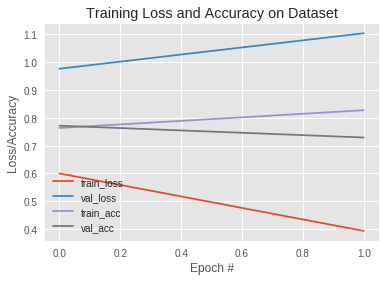

In [0]:
%matplotlib inline  

# plot the training loss and accuracy
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
#plt.savefig(args["plot"])